In [35]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import json
import nltk #error in summac since SummaC uses NLTK’s sentence tokenizer, which relies on a pre-trained model called punkt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM #, Trainer, TrainingArguments
from IPython.display import SVG, display
from tqdm.notebook import tqdm
from rouge_score import rouge_scorer
from bert_score import score
# from summac.model_summac import SummaCZS, SummaCConv #this is not compatible with transformers so have to disable and re-enable when used
from bertviz import model_view

In [4]:
# xsum = load_dataset("xsum", data_dir = "/Users/alvin/cursorfiles/projects/NLP/Final Project/models/data/xsum", trust_remote_code = True)
xsum = load_dataset("EdinburghNLP/xsum", trust_remote_code = True)

In [5]:
print(xsum["train"][0])  # Should print a sample with "document" and "summary"

{'document': 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall did not fail.\n"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally apprecia

In [7]:
#same as the cnn version
pegasus_model_normal_xsum = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-large")
pegasus_tokenizer_normal_xsum = AutoTokenizer.from_pretrained("google/pegasus-large")

bart_model_normal_xsum = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large")
bart_tokenizer_normal_xsum = AutoTokenizer.from_pretrained("facebook/bart-large")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# XSum-Finetuned models 
pegasus_model_xsum = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-xsum")
pegasus_tokenizer_xsum = AutoTokenizer.from_pretrained("google/pegasus-xsum")

bart_model_xsum = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-xsum")
bart_tokenizer_xsum = AutoTokenizer.from_pretrained("facebook/bart-large-xsum")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Configure threads BEFORE any PyTorch operations
torch.set_num_threads(4)  # Controls intra-op parallelism

def create_comparison_dataset(dataset, model_1, tokenizer_1, model_2, tokenizer_2, num_samples=5):
    comparisons = []
    device = torch.device('cpu')
    
    # Move models to CPU
    model_1 = model_1.to(device).eval()
    model_2 = model_2.to(device).eval()
    
    # REMOVED THREAD CONFIG HERE (ALREADY SET AT TOP)
    
    def summarize_with_device(text, model, tokenizer):
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=512,
            padding="max_length"
        )
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            num_beams=4,
            early_stopping=True
        )
        return tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    for i in tqdm(range(num_samples), desc="Processing articles"):
        try:
            example = dataset['test'][i]
            article = example.get('article') or example.get('document')
            ground_truth = example.get('highlights') or example.get('summary')
            
            pegasus_summary = summarize_with_device(article, model_1, tokenizer_1)
            bart_summary = summarize_with_device(article, model_2, tokenizer_2)
            
            comparisons.append({
                'article': article,
                'ground_truth': ground_truth,
                'pegasus_summary': pegasus_summary,
                'bart_summary': bart_summary
            })
            
        except Exception as e:
            print(f"Error processing sample {i}: {str(e)}")
            continue
    
    return comparisons

In [ ]:
#compairson dataset for xsum normal
xsum_summary_comparison_normal = create_comparison_dataset(xsum, pegasus_model_normal_xsum, pegasus_tokenizer_normal_xsum, bart_model_normal_xsum, bart_tokenizer_normal_xsum, num_samples = 100)

In [ ]:
#compairson dataset for xsum pretrained
xsum_summary_comparison = create_comparison_dataset(xsum, pegasus_model_xsum, pegasus_tokenizer_xsum, bart_model_xsum, bart_tokenizer_xsum, num_samples = 100)

In [11]:
# For loading from pickle
def load_comparisons_from_pickle(filename="summary_comparisons.pkl"):
    with open(filename, 'rb') as f:
        comparisons = pickle.load(f)
    print(f"Loaded {len(comparisons)} comparisons from {filename}")
    return comparisons

# For loading from CSV
def load_comparisons_from_csv(filename="summary_comparisons.csv"):
    df = pd.read_csv(filename)
    comparisons = df.to_dict('records')
    print(f"Loaded {len(comparisons)} comparisons from {filename}")
    return comparisons

In [12]:
xsum_summary_comparison_normal = load_comparisons_from_pickle(filename="data_comparison/xsum_summary_normal_comparison.pkl")
xsum_summary_comparison = load_comparisons_from_pickle(filename="data_comparison/xsum_summary_comparison.pkl")

Loaded 100 comparisons from data_comparison/xsum_summary_normal_comparison.pkl
Loaded 100 comparisons from data_comparison/xsum_summary_comparison.pkl


In [13]:
print(xsum_summary_comparison)

[{'article': 'Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.\nWorkers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders.\nThe Welsh Government said more people than ever were getting help to address housing problems.\nChanges to the Housing Act in Wales, introduced in 2015, removed the right for prison leavers to be given priority for accommodation.\nPrison Link Cymru, which helps people find accommodation after their release, said things were generally good for women because issues such as children or domestic violence were now considered.\nHowever, the same could not be said for men, the charity said, because issues which often affect them, such as post traumatic stress disorder or drug dependency, were often viewed as less of a priority.\nAndrew Stevens, who works in Welsh prisons trying to secure housing for prison leavers, said the

In [16]:
def evaluate_summaries(comparisons):
    # Initialize ROUGE scorer with different ROUGE variants
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True) #Use Porter stemmer to strip word suffixes to improve matching
    
    results = {
        'pegasus': {'rouge1': [], 'rouge2': [], 'rougeL': []},
        'bart': {'rouge1': [], 'rouge2': [], 'rougeL': []}
    }
    
    for comparison in comparisons:
        # Evaluate Pegasus summary
        pegasus_scores = scorer.score(comparison['ground_truth'], comparison['pegasus_summary'])
        for metric in ['rouge1', 'rouge2', 'rougeL']:
            results['pegasus'][metric].append(pegasus_scores[metric].fmeasure)
        
        # Evaluate BART summary
        bart_scores = scorer.score(comparison['ground_truth'], comparison['bart_summary'])
        for metric in ['rouge1', 'rouge2', 'rougeL']:
            results['bart'][metric].append(bart_scores[metric].fmeasure)
    
    # Calculate average scores
    avg_results = {
        'pegasus': {metric: np.mean(scores) for metric, scores in results['pegasus'].items()},
        'bart': {metric: np.mean(scores) for metric, scores in results['bart'].items()}
    }
    
    return {
        'detailed_results': results,
        'average_results': avg_results
    }

In [17]:
xsum_evaluation = evaluate_summaries(xsum_summary_comparison)

# Print average results
print("\nXSum Results:")
print(f"Pegasus: {xsum_evaluation['average_results']['pegasus']}")
print(f"BART: {xsum_evaluation['average_results']['bart']}")


XSum Results:
Pegasus: {'rouge1': np.float64(0.48513058564996137), 'rouge2': np.float64(0.2628850405702444), 'rougeL': np.float64(0.4132744308730962)}
BART: {'rouge1': np.float64(0.44562660091695877), 'rouge2': np.float64(0.22168367927626917), 'rougeL': np.float64(0.37317776631459126)}


In [19]:
xsum_evaluation = evaluate_summaries(xsum_summary_comparison_normal)

# Print average results
print("\nXSum Results:")
print(f"Pegasus: {xsum_evaluation['average_results']['pegasus']}")
print(f"BART: {xsum_evaluation['average_results']['bart']}")


XSum Results:
Pegasus: {'rouge1': np.float64(0.18003438906799143), 'rouge2': np.float64(0.028412238046479844), 'rougeL': np.float64(0.12070880190926045)}
BART: {'rouge1': np.float64(0.17038345031729704), 'rouge2': np.float64(0.03487360320149642), 'rougeL': np.float64(0.11076938313849391)}


Error: not specifying model type can cause issues since it might pick an unsupported model type like deta

In [21]:
def evaluate_BERTScore(candidates, references): #references are the ground truth and candidates are inferences
    P, R, F1 = score(candidates, references, lang = "en", verbose = True)
    return {"precision" : P.mean().item(),
            "recall" : R.mean().item(),
            "f1" : F1.mean().item()}

In [22]:
# Extract lists from your comparisons
references = [comparison['ground_truth'] for comparison in xsum_summary_comparison]
pegasus_candidates = [comparison['pegasus_summary'] for comparison in xsum_summary_comparison]
bart_candidates = [comparison['bart_summary'] for comparison in xsum_summary_comparison]

# Calculate BERTScore for Pegasus model outputs
evaluate_BERTScore(pegasus_candidates, references)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 13.73 seconds, 7.28 sentences/sec


{'precision': 0.9262813329696655,
 'recall': 0.9138551354408264,
 'f1': 0.9199146032333374}

In [23]:
evaluate_BERTScore(bart_candidates, references)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 13.07 seconds, 7.65 sentences/sec


{'precision': 0.9178205728530884,
 'recall': 0.9117816090583801,
 'f1': 0.9146287441253662}

In [24]:
# Extract lists from your comparisons
references = [comparison['ground_truth'] for comparison in xsum_summary_comparison_normal]
pegasus_candidates = [comparison['pegasus_summary'] for comparison in xsum_summary_comparison_normal]
bart_candidates = [comparison['bart_summary'] for comparison in xsum_summary_comparison_normal]

# Calculate BERTScore for Pegasus model outputs
evaluate_BERTScore(pegasus_candidates, references)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 25.14 seconds, 3.98 sentences/sec


{'precision': 0.8385425806045532,
 'recall': 0.8649487495422363,
 'f1': 0.8513086438179016}

In [25]:
evaluate_BERTScore(bart_candidates, references)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 34.23 seconds, 2.92 sentences/sec


{'precision': 0.8204026818275452,
 'recall': 0.8767812848091125,
 'f1': 0.8475058078765869}

In [27]:
def evaluate_factual_consistency(comparisons):
    # Initialize SummaC models
    #getting CUDA error so forcing it to run on cpu since older libraries does not have mps?
    summac_zs = SummaCZS(granularity="sentence", model_name="vitc", device="cpu") # Initialize SummaC explicitly on CPU
    summac_conv = SummaCConv(models=["vitc"], granularity="sentence", device="cpu")
    
    # Prepare data
    documents = [comp['article'] for comp in comparisons]
    pegasus_summaries = [comp['pegasus_summary'] for comp in comparisons]
    bart_summaries = [comp['bart_summary'] for comp in comparisons]

    # Evaluate with progress bars
    def score_with_progress(model, documents, summaries, desc):
        scores = []
        for doc, sum in tqdm(zip(documents, summaries), total=len(documents), desc=desc):
            scores.append(model.score([doc], [sum])["scores"][0])
        return {"scores": scores}
    
    # Evaluate with SummaC-ZS
    pegasus_zs_scores = score_with_progress(summac_zs, documents, pegasus_summaries, "Pegasus SummaC-ZS")
    bart_zs_scores = score_with_progress(summac_zs, documents, bart_summaries, "BART SummaC-ZS")

    # Evaluate with SummaC-Conv
    pegasus_conv_scores = score_with_progress(summac_conv, documents, pegasus_summaries, "Pegasus SummaC-Conv")
    bart_conv_scores = score_with_progress(summac_conv, documents, bart_summaries, "BART SummaC-Conv")

    
    return {
        "pegasus": {
            "summac_zs_mean": np.mean(pegasus_zs_scores['scores']),
            "summac_conv_mean": np.mean(pegasus_conv_scores['scores']),
            "raw_zs": pegasus_zs_scores['scores'],  # Add raw scores
            "raw_conv": pegasus_conv_scores['scores']
        },
        "bart": {
            "summac_zs_mean": np.mean(bart_zs_scores['scores']),
            "summac_conv_mean": np.mean(bart_conv_scores['scores']),
            "raw_zs": bart_zs_scores['scores'],  # Add raw scores
            "raw_conv": bart_conv_scores['scores']
        }
    }

In [ ]:
summaC_Xsum_scores = evaluate_factual_consistency(xsum_summary_comparison)

In [ ]:
print(json.dumps(summaC_Xsum_scores, indent=2))

In [ ]:
# Save results to a file
with open("summac_scores_xsum.json", "w") as f:
    json.dump(summaC_Xsum_scores, f)  # Saves raw scores and means

In [36]:
def get_attention_full(model, tokenizer, article):
    inputs = tokenizer(article, return_tensors="pt", truncation=True, max_length=512)
    summary_ids = model.generate(
        **inputs,
        max_length=60,
        num_beams=5,
        early_stopping=True,
        return_dict_in_generate=True
    )
    if hasattr(summary_ids, "sequences"):
        summary_ids = summary_ids.sequences
    outputs = model(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        decoder_input_ids=summary_ids,
        output_attentions=True,
        return_dict=True
    )
    cross_attentions = outputs.cross_attentions
    encoder_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    decoder_tokens = tokenizer.convert_ids_to_tokens(summary_ids[0])
    return cross_attentions, encoder_tokens, decoder_tokens
    
def plot_attention_single_head(cross_attentions, encoder_tokens, decoder_tokens, layer=2, head=0):
    attn = cross_attentions[layer][0, head].detach().numpy()
    plot_attention(attn, encoder_tokens, decoder_tokens, f"Layer {layer}, Head {head}")
def plot_attention_avg_heads(cross_attentions, encoder_tokens, decoder_tokens, layer=2):
    attn = cross_attentions[layer][0].mean(dim=0).detach().numpy()
    plot_attention(attn, encoder_tokens, decoder_tokens, f"Avg Across Heads (Layer {layer})")
def plot_attention_avg_all(cross_attentions, encoder_tokens, decoder_tokens):
    stacked = torch.stack(cross_attentions)  # shape: (layers, batch, heads, tgt_len, src_len)
    attn = stacked.mean(dim=(0, 2))[0].detach().numpy()
    plot_attention(attn, encoder_tokens, decoder_tokens, "Avg Across All Layers & Heads")

def plot_attention(attn, x_tokens, y_tokens, title, max_tokens=50):
    x_tokens = x_tokens[:max_tokens]
    y_tokens = y_tokens[:max_tokens]
    attn = attn[:len(y_tokens), :len(x_tokens)]

    plt.figure(figsize=(14, 10))
    sns.heatmap(attn, xticklabels=x_tokens, yticklabels=y_tokens, cmap="viridis")
    plt.title(title)
    plt.xlabel("Decoder (Summary) Tokens")
    plt.ylabel("Encoder (Article) Tokens")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

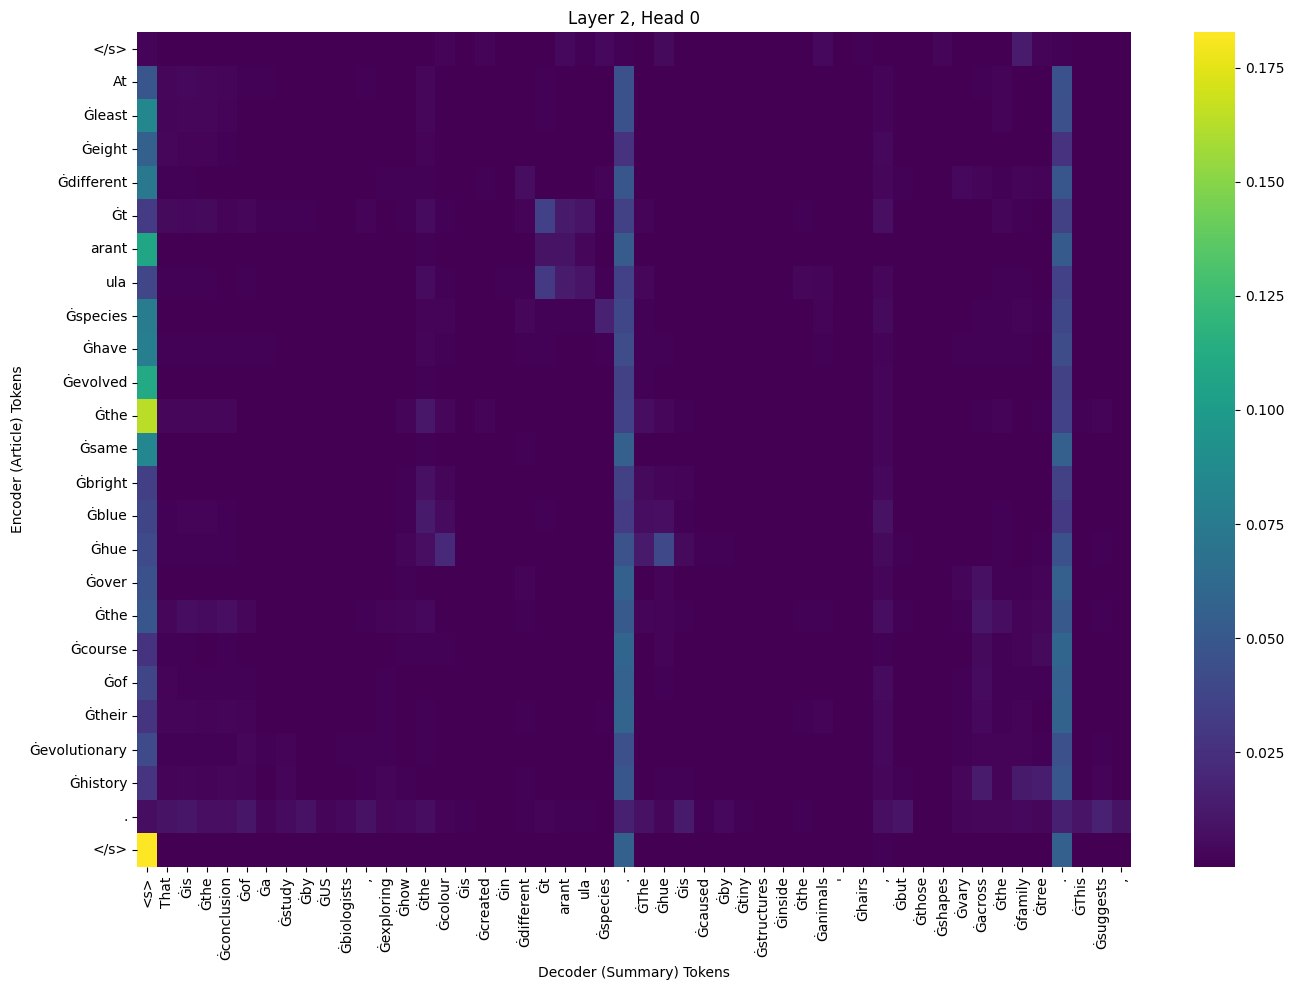

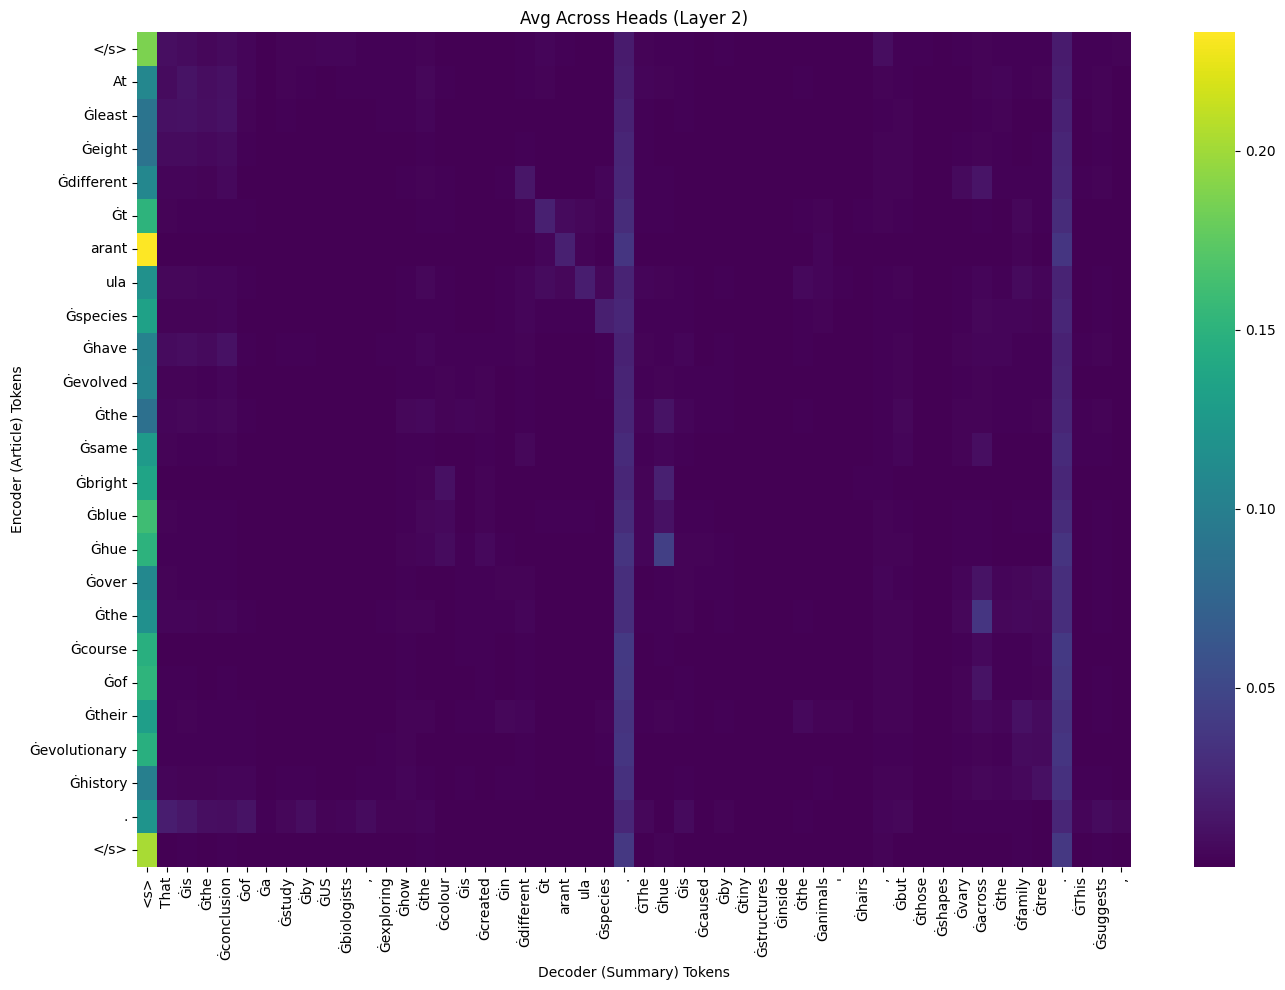

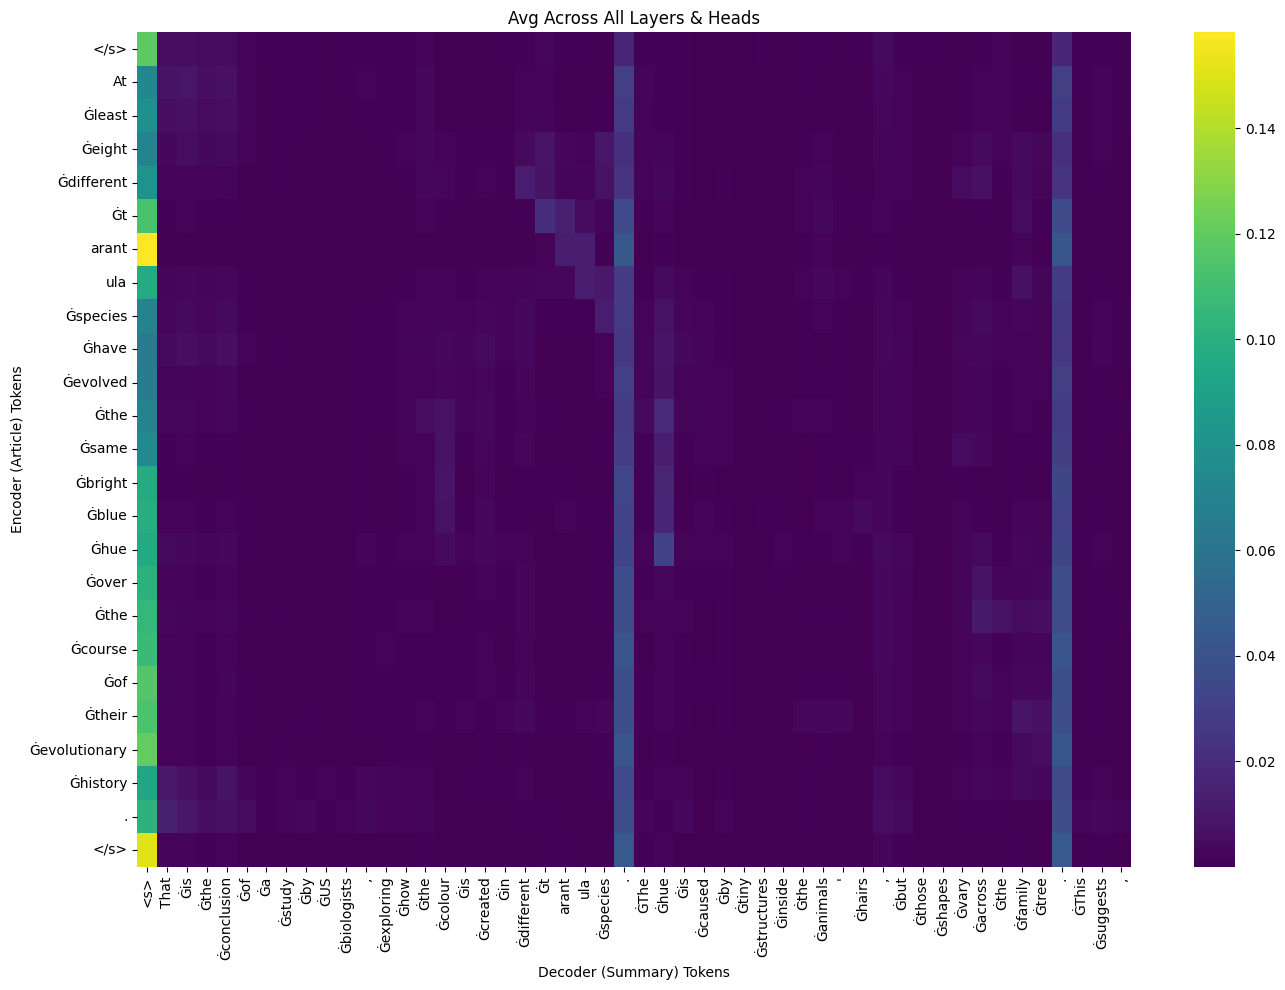

In [39]:
# using id = 34944735
article = """That is the conclusion of a study by US biologists, exploring how the colour is created in different tarantula species. The hue is caused by tiny structures inside the animals' hairs, but those shapes vary across the family tree. This suggests, the researchers say, that the striking blue is not driven by sexual selection - unlike many other bright colours in the animal kingdom. This argument is also supported by the fact that tarantulas have poor colour vision, and do not appear to show off their hairy blue body parts during courtship. Nonetheless, Bor-Kai Hsiung and his colleagues found that 40 out of 53 groupings (genera) of tarantula exhibit a very vibrant blue. "We collected published data and constructed a super-tree, which combined the previous published small trees," said Mr Hsiung, a PhD student at the University of Akron in Ohio and the first author of the study, published in Science Advances. They then mapped blueness onto that evolutionary tree, based on a bank of tarantula snaps scoured from the internet. "If the genus has at least one species that's blue, we say that's a blue genus," Mr Hsiung explained. Given that scattering of blue species, he added, they then calculated "the lowest number of changes that can produce a distribution of blue colouring like this". The answer? "Eight is the lowest number, so it's [evolved] at least eight times." What is more, all these blue spiders evolved almost precisely the same shade; the wavelengths the team saw in the images all fell within a tight 20 nanometre range, clustered around 450nm - a bright, cobalt blue. The team also purchased specimens of eight tarantula species, and took a close look at those blue hairs. They used electron microscopes to zoom in on tiny shapes within the hairs and conducted simulations of how those shapes could produce a "structural colour" by reflecting - very specifically - this wavelength of blue light. The results, again, pointed to the colour cropping up multiple times independently: several different types of shape could be seen, even on the same branch of the family tree. "That's one of the reasons why it must have evolved so many times - because we don't see a very clear pattern of how these different mechanisms split," Mr Hsiung said. "If we could see a clear split, then it might have evolved just one or two times. But it's all over the place." So why did all these different species acquire the same colour? Given their relatively simple eyes, it is doubtful that tarantulas can distinguish this shade of blue from any other colour. That is one of the reasons that sexual selection seems unlikely - by contrast with some other spiders, which have remarkably good vision and put on very colourful courtship displays, such as the mesmerising peacock spider. "It evolved from multiple origins and different mechanisms produce the very same blue colour," Mr Hsiung said. "That's very strong evidence to suggest that this blue colour has a very important visual signalling function. "But if it's not for other tarantulas, then it must be to some other receivers out there." It may be that this colour helps conceal the critters from their prey while they hunt at night; or perhaps it serves as a warning to stop the tarantulas themselves being eaten. "We don't know yet," Mr Hsiung said. Follow Jonathan on Twitter"""
cross_att, enc_toks, dec_toks = get_attention_full(bart_model_normal_xsum, bart_tokenizer_normal_xsum, article)

plot_attention_single_head(cross_att, enc_toks, dec_toks, layer=2, head=0)
plot_attention_avg_heads(cross_att, enc_toks, dec_toks, layer=2)
plot_attention_avg_all(cross_att, enc_toks, dec_toks)

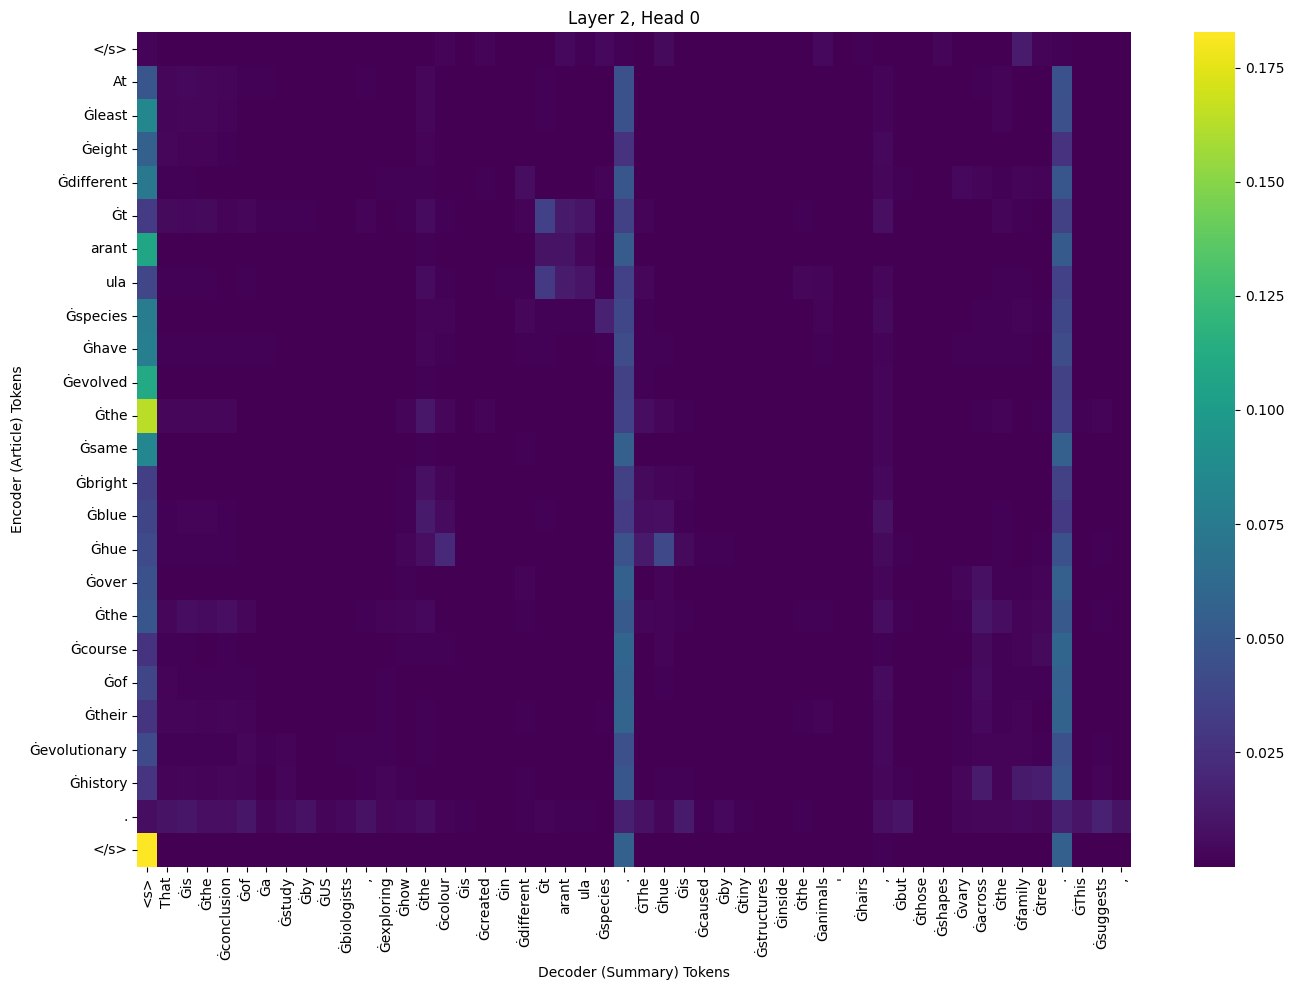

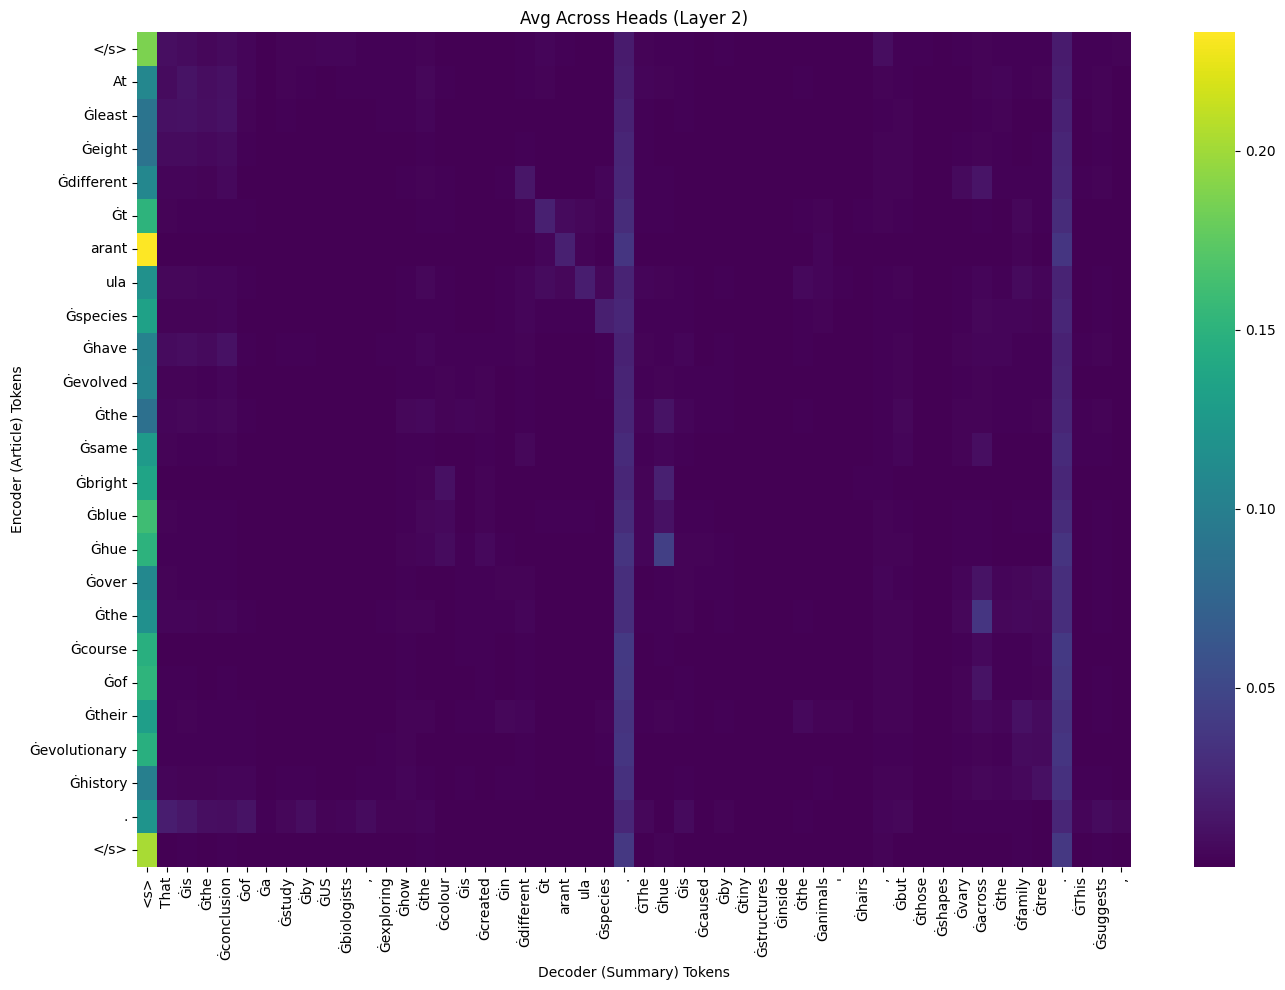

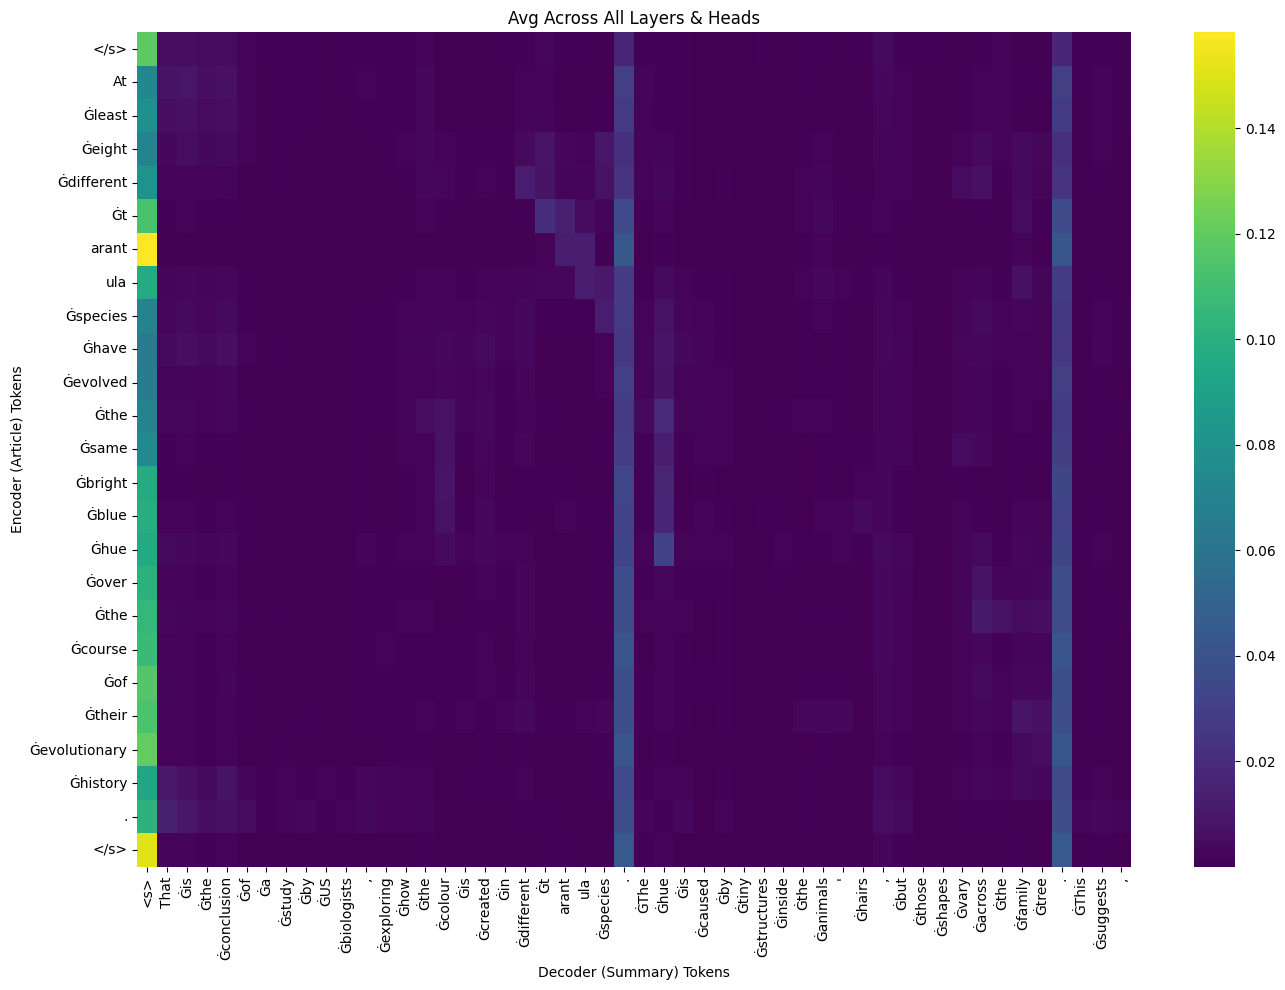

In [40]:
# using id = 34944735 trying pretrained bart to see if I can get diagonals 
article = """That is the conclusion of a study by US biologists, exploring how the colour is created in different tarantula species. The hue is caused by tiny structures inside the animals' hairs, but those shapes vary across the family tree. This suggests, the researchers say, that the striking blue is not driven by sexual selection - unlike many other bright colours in the animal kingdom. This argument is also supported by the fact that tarantulas have poor colour vision, and do not appear to show off their hairy blue body parts during courtship. Nonetheless, Bor-Kai Hsiung and his colleagues found that 40 out of 53 groupings (genera) of tarantula exhibit a very vibrant blue. "We collected published data and constructed a super-tree, which combined the previous published small trees," said Mr Hsiung, a PhD student at the University of Akron in Ohio and the first author of the study, published in Science Advances. They then mapped blueness onto that evolutionary tree, based on a bank of tarantula snaps scoured from the internet. "If the genus has at least one species that's blue, we say that's a blue genus," Mr Hsiung explained. Given that scattering of blue species, he added, they then calculated "the lowest number of changes that can produce a distribution of blue colouring like this". The answer? "Eight is the lowest number, so it's [evolved] at least eight times." What is more, all these blue spiders evolved almost precisely the same shade; the wavelengths the team saw in the images all fell within a tight 20 nanometre range, clustered around 450nm - a bright, cobalt blue. The team also purchased specimens of eight tarantula species, and took a close look at those blue hairs. They used electron microscopes to zoom in on tiny shapes within the hairs and conducted simulations of how those shapes could produce a "structural colour" by reflecting - very specifically - this wavelength of blue light. The results, again, pointed to the colour cropping up multiple times independently: several different types of shape could be seen, even on the same branch of the family tree. "That's one of the reasons why it must have evolved so many times - because we don't see a very clear pattern of how these different mechanisms split," Mr Hsiung said. "If we could see a clear split, then it might have evolved just one or two times. But it's all over the place." So why did all these different species acquire the same colour? Given their relatively simple eyes, it is doubtful that tarantulas can distinguish this shade of blue from any other colour. That is one of the reasons that sexual selection seems unlikely - by contrast with some other spiders, which have remarkably good vision and put on very colourful courtship displays, such as the mesmerising peacock spider. "It evolved from multiple origins and different mechanisms produce the very same blue colour," Mr Hsiung said. "That's very strong evidence to suggest that this blue colour has a very important visual signalling function. "But if it's not for other tarantulas, then it must be to some other receivers out there." It may be that this colour helps conceal the critters from their prey while they hunt at night; or perhaps it serves as a warning to stop the tarantulas themselves being eaten. "We don't know yet," Mr Hsiung said. Follow Jonathan on Twitter"""
cross_att, enc_toks, dec_toks = get_attention_full(bart_model_xsum, bart_tokenizer_xsum, article)

plot_attention_single_head(cross_att, enc_toks, dec_toks, layer=2, head=0)
plot_attention_avg_heads(cross_att, enc_toks, dec_toks, layer=2)
plot_attention_avg_all(cross_att, enc_toks, dec_toks)

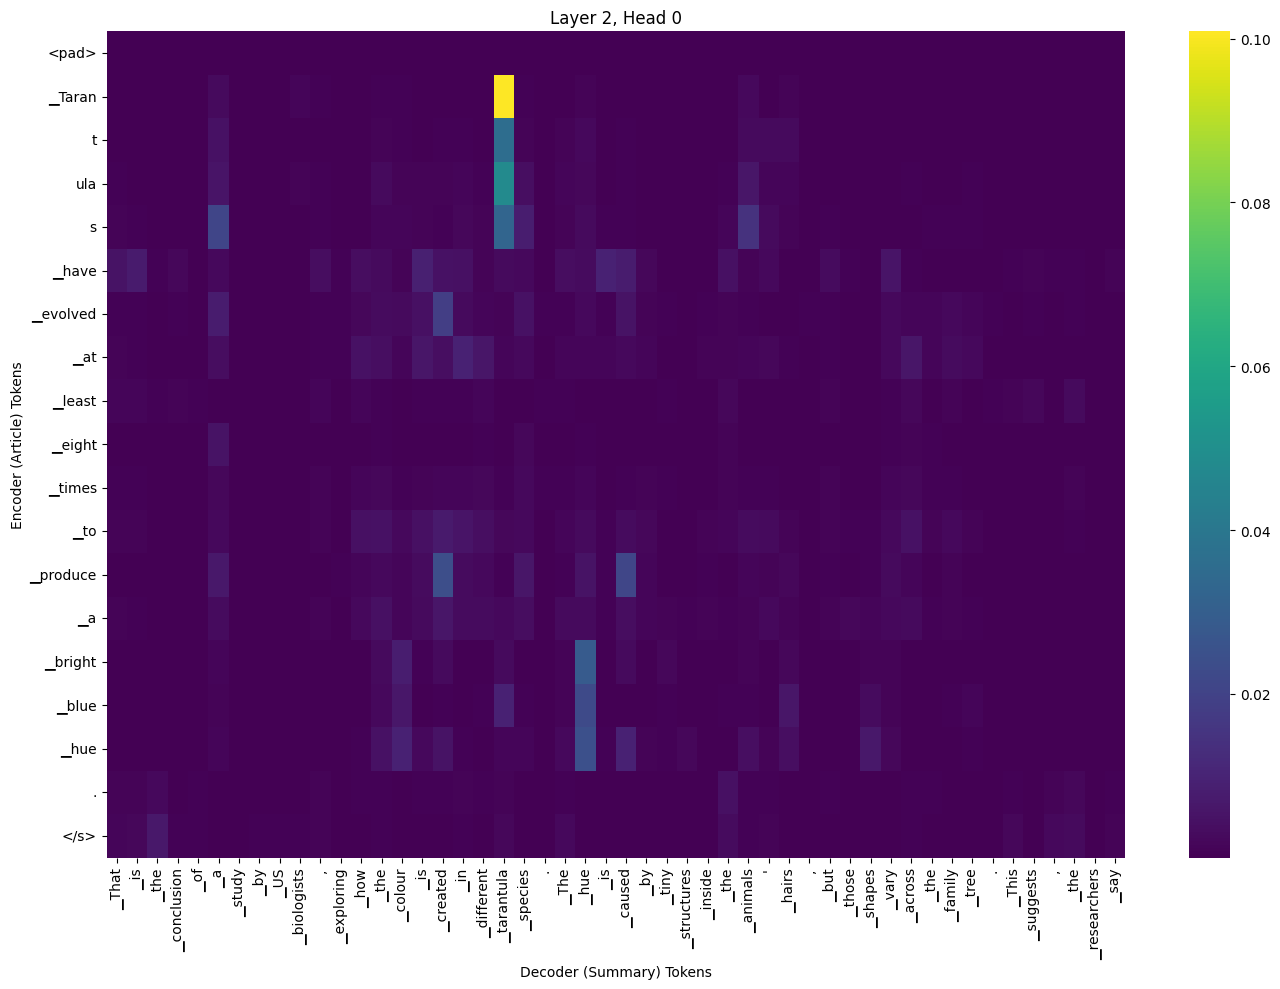

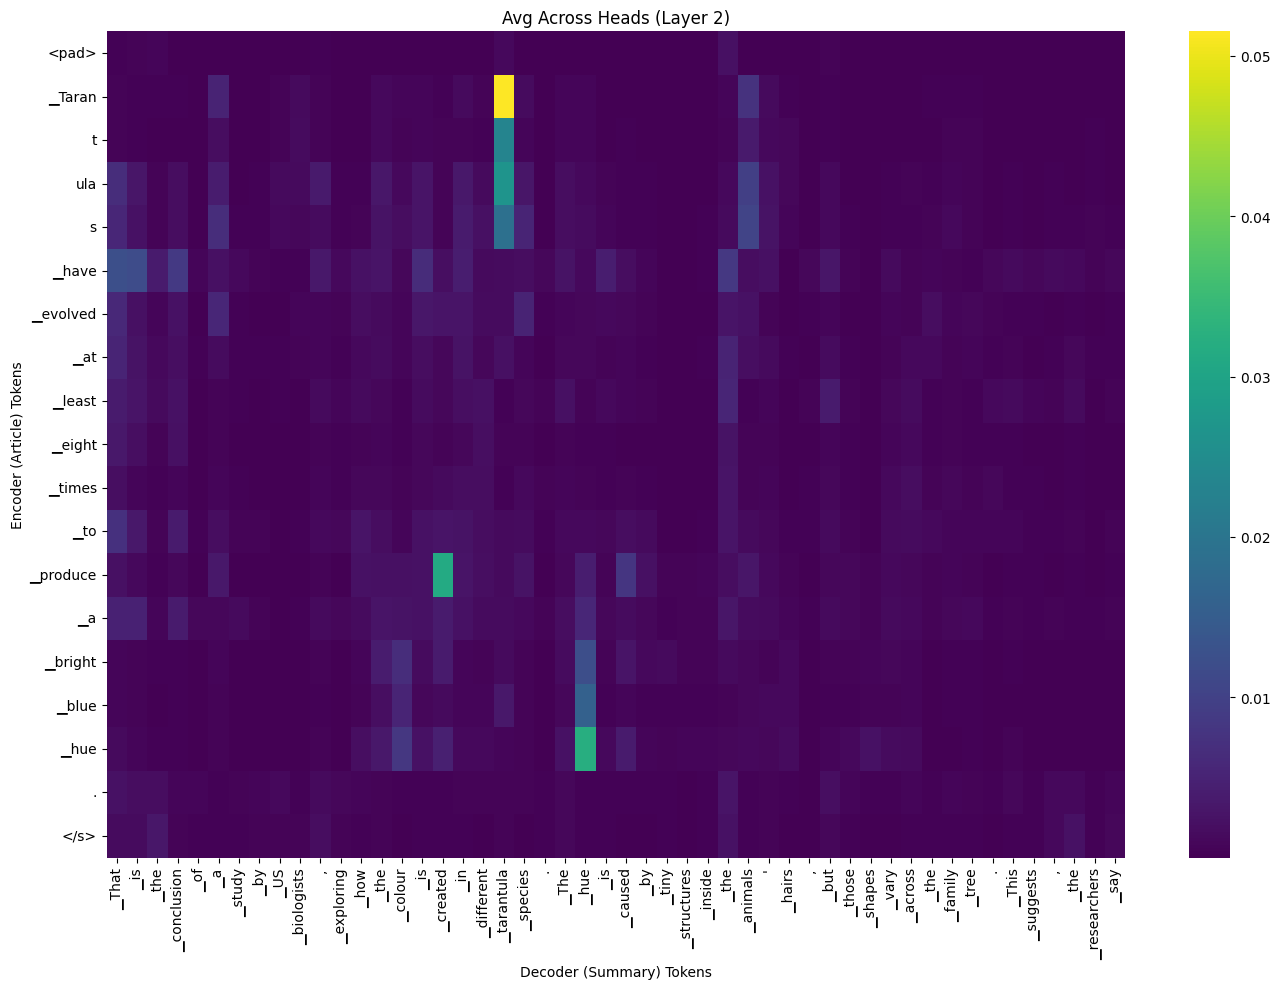

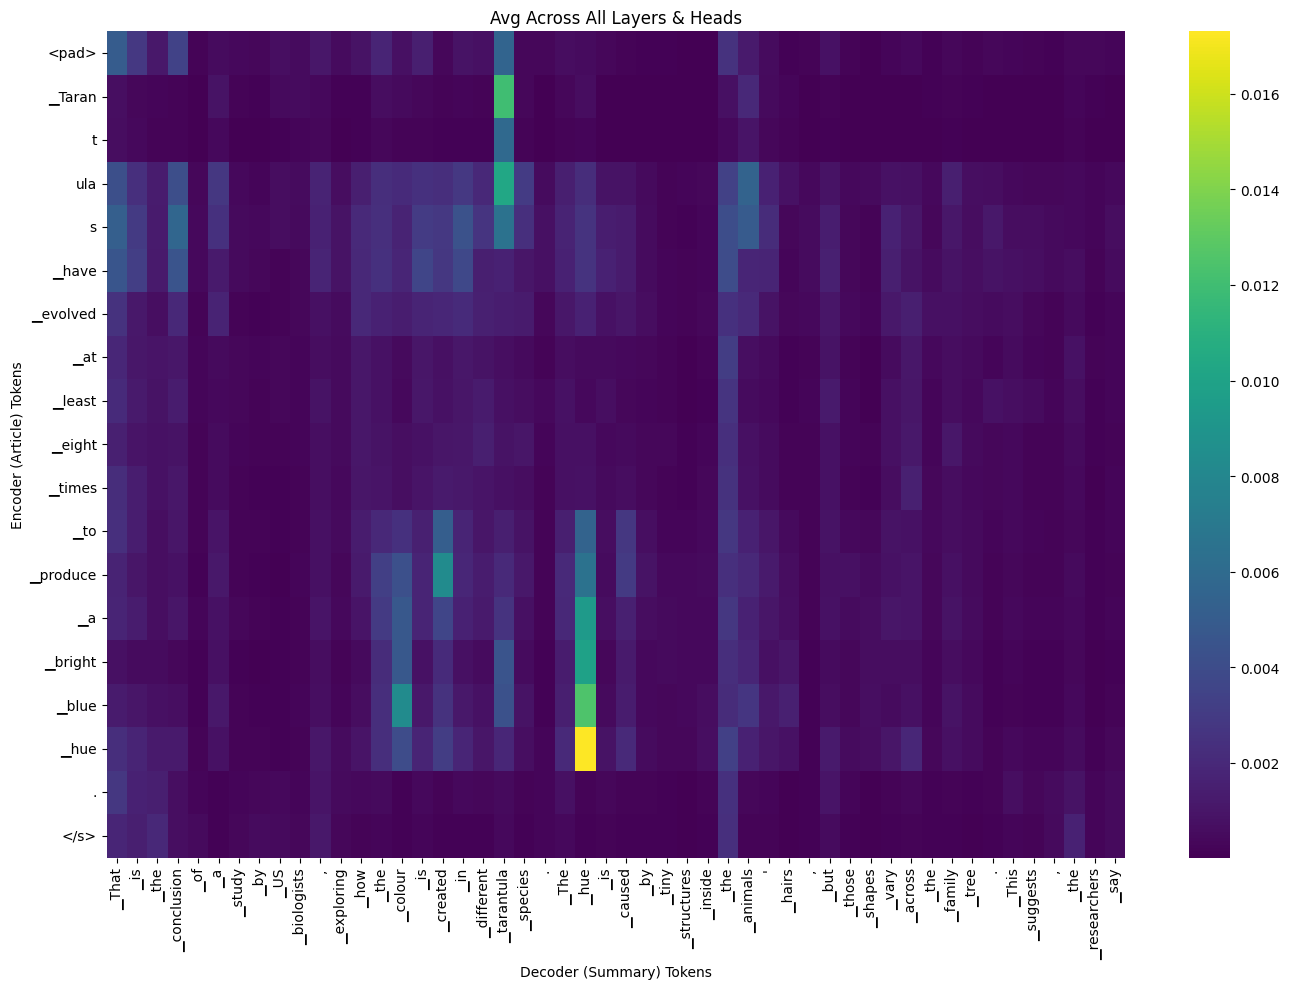

In [38]:
# using id = 34944735
article = """That is the conclusion of a study by US biologists, exploring how the colour is created in different tarantula species. The hue is caused by tiny structures inside the animals' hairs, but those shapes vary across the family tree. This suggests, the researchers say, that the striking blue is not driven by sexual selection - unlike many other bright colours in the animal kingdom. This argument is also supported by the fact that tarantulas have poor colour vision, and do not appear to show off their hairy blue body parts during courtship. Nonetheless, Bor-Kai Hsiung and his colleagues found that 40 out of 53 groupings (genera) of tarantula exhibit a very vibrant blue. "We collected published data and constructed a super-tree, which combined the previous published small trees," said Mr Hsiung, a PhD student at the University of Akron in Ohio and the first author of the study, published in Science Advances. They then mapped blueness onto that evolutionary tree, based on a bank of tarantula snaps scoured from the internet. "If the genus has at least one species that's blue, we say that's a blue genus," Mr Hsiung explained. Given that scattering of blue species, he added, they then calculated "the lowest number of changes that can produce a distribution of blue colouring like this". The answer? "Eight is the lowest number, so it's [evolved] at least eight times." What is more, all these blue spiders evolved almost precisely the same shade; the wavelengths the team saw in the images all fell within a tight 20 nanometre range, clustered around 450nm - a bright, cobalt blue. The team also purchased specimens of eight tarantula species, and took a close look at those blue hairs. They used electron microscopes to zoom in on tiny shapes within the hairs and conducted simulations of how those shapes could produce a "structural colour" by reflecting - very specifically - this wavelength of blue light. The results, again, pointed to the colour cropping up multiple times independently: several different types of shape could be seen, even on the same branch of the family tree. "That's one of the reasons why it must have evolved so many times - because we don't see a very clear pattern of how these different mechanisms split," Mr Hsiung said. "If we could see a clear split, then it might have evolved just one or two times. But it's all over the place." So why did all these different species acquire the same colour? Given their relatively simple eyes, it is doubtful that tarantulas can distinguish this shade of blue from any other colour. That is one of the reasons that sexual selection seems unlikely - by contrast with some other spiders, which have remarkably good vision and put on very colourful courtship displays, such as the mesmerising peacock spider. "It evolved from multiple origins and different mechanisms produce the very same blue colour," Mr Hsiung said. "That's very strong evidence to suggest that this blue colour has a very important visual signalling function. "But if it's not for other tarantulas, then it must be to some other receivers out there." It may be that this colour helps conceal the critters from their prey while they hunt at night; or perhaps it serves as a warning to stop the tarantulas themselves being eaten. "We don't know yet," Mr Hsiung said. Follow Jonathan on Twitter"""
cross_att, enc_toks, dec_toks = get_attention_full(pegasus_model_normal_xsum, pegasus_tokenizer_normal_xsum, article)

plot_attention_single_head(cross_att, enc_toks, dec_toks, layer=2, head=0)
plot_attention_avg_heads(cross_att, enc_toks, dec_toks, layer=2)
plot_attention_avg_all(cross_att, enc_toks, dec_toks)